# Analyzing pathways and controls
This example demonstrates Connectome Utilities functions to turn a simple "atomic" analysis into something more complex, by automatically applying it to discrete or overlapping populations. Additionally, it demonstrates the ability to handle control models and compare the results of an analysis between control and data.


We begin by loading data. In this example, we load neuron-to-neuron connectivity of a few thousand neurons in a biologically detailed model. It also loads a list of "properties" associated with the nodes (neurons), such as their locations in two different coordinate systems.

We demonstrate how the data would be loaded from a circuit model in Sonata format, but in case you don't have a Sonata circuit available, there is also a serialized version provided with this repository.

In [2]:
import numpy, pandas
import bluepy
import conntility
import os

from scipy.spatial import distance
from matplotlib import pyplot as plt


# Describes which node properties to load and filtering based on them
# This loads a small subvolume of aorund 6.5k nodes
load_cfg = {
    "loading":{    
        "properties": ["x", "y", "z", "mtype", "layer", "synapse_class", "ss_flat_x", "ss_flat_y", "depth"]
    },
    "filtering":[
        {
            "column": "synapse_class",
            "values": ["EXC"]
        },
        {
            "column": "layer",
            "values": [2, 3]
        },
        {
            "column": "ss_flat_x",
            "interval": [2000, 2400]
        },
        {
            "column": "ss_flat_y",
            "interval": [2000, 2400]
        }
    ]
}

# Some additional configuration
fn_circ = "/gpfs/bbp.cscs.ch/project/proj83/circuits/Bio_M/20200805/CircuitConfig_TC_WM"
fn_con_mat = "L23_EXC_sampled_cmat.h5"
columns_slice=["ss_flat_x", "ss_flat_y"]
column_y = "depth"
population = "default"

# Since you may not have access to the Sonata circuit this example is based on, we provide the result also in hdf5
if os.path.exists(fn_con_mat):
    cmat = conntility.ConnectivityMatrix.from_h5(fn_con_mat)
else:
    circ = bluepy.Circuit(fn_circ)
    cmat = conntility.ConnectivityMatrix.from_bluepy(circ, load_config=load_cfg, population=population)
    cmat.to_h5(fn_con_mat)

For analysis, of course it is possible to run whatever code we want on the adjacency matrix

Text(0, 0.5, 'Count')

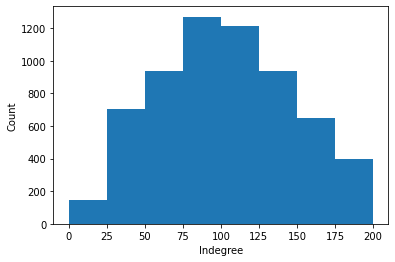

In [3]:
indeg_bins = [0, 25, 50, 75, 100, 125, 150, 175, 200]

H = numpy.histogram(cmat.matrix.sum(axis=0), bins=indeg_bins)[0]
plt.bar(indeg_bins[:-1], H, width=25, align="edge")
plt.gca().set_xlabel("Indegree")
plt.gca().set_ylabel("Count")

But for more complex analyses we would codify the details in an _analysis configuration_ file.
Note that the actual underlying analysis is typically not part of the Connectome Utilities but assumed to exist in a python file or package somewhere else. Connectome Utilities just provides the means to execute the analysis efficiently for separate subnetworks, or generate controls and compare to them.

We will begin by running a primitive analysis on the network. It is dynamically imported from a python file. Since this is just an example, we write that file to contain a primitive analysis counting the number of connections.

In [4]:
with open("simple_analysis_example.py", "w") as fid:
    fid.write("""
def count_connections(mat, nrn):
    return mat.nnz

"""
             )
analysis_specs = {
    "analyses":{
        "connection_counts": {
            "source": "simple_analysis_example.py",
            "method": "count_connections",
            "output": "scalar"
        }
    }
}
cmat.analyze(analysis_specs)


{'connection_counts': 755427}

This was very primitive and hardly worth writing a configuration for.
But we can perform much more involved analyses by stacking decorators onto the base analysis.

For example, we can analyze different subpopulations separately. 
To do this, we specify the name of the node property to use to define the groups. In the first example, we will use the "mtype" property and the resulting groups will be all unique values of that property.

The sub-matrices to be analyzed separately as a result can be defined in several different ways. Let M be the matrix and g be a group. Then:

"grouped_presyn_by_grouping_config" analyses separately the M[g, :]

"grouped_postsyn_by_grouping_config" analyses separately the M[:, g]

"grouped_subpop_by_grouping_config" analyses separately the M[numpy.ix_(g, g)]


In [5]:
analysis_specs = {
    "analyses":{
        "connection_counts_from_type": {
            "source": "simple_analysis_example.py",
            "method": "count_connections",
            "output": "scalar",
            "decorators": [
                {
                    "name": "grouped_presyn_by_grouping_config",
                    "args": [{"columns": ["mtype"], "method": "group_by_properties"}]
                }
            ]
        },
        "connection_counts_to_type": {
            "source": "simple_analysis_example.py",
            "method": "count_connections",
            "output": "scalar",
            "decorators": [
                {
                    "name": "grouped_postsyn_by_grouping_config",
                    "args": [{"columns": ["mtype"], "method": "group_by_properties"}]
                }
            ]
        },
        "connection_counts_within_type": {
            "source": "simple_analysis_example.py",
            "method": "count_connections",
            "output": "scalar",
            "decorators": [
                {
                    "name": "grouped_subpop_by_grouping_config",
                    "args": [{"columns": ["mtype"], "method": "group_by_properties"}]
                }
            ]
        }
    }
}
cmat.analyze(analysis_specs)

{'connection_counts_from_type': idx-mtype
 L2_IPC       29333
 L2_TPC:A     27102
 L2_TPC:B    297207
 L3_TPC:A    301641
 L3_TPC:C    100144
 dtype: int64,
 'connection_counts_to_type': idx-mtype
 L2_IPC       23784
 L2_TPC:A     21169
 L2_TPC:B    216752
 L3_TPC:A    392608
 L3_TPC:C    101114
 dtype: int64,
 'connection_counts_within_type': idx-mtype
 L2_IPC        1227
 L2_TPC:A      1079
 L2_TPC:B    120911
 L3_TPC:A    187127
 L3_TPC:C     15305
 dtype: int64}

Simimlarly, "pathways_by_grouping_config" analyses separately the M[a, b] for all pairs of groups a, b.
Also note that more than one property ("column") can be provided. In that case, the groups are given by the cartesian product of the values of the two properties.

In [6]:
analysis_specs = {
    "analyses":{
        "connection_counts_for_pathways": {
            "source": "simple_analysis_example.py",
            "method": "count_connections",
            "output": "scalar",
            "decorators": [
                {
                    "name": "pathways_by_grouping_config",
                    "args": [{"columns": ["mtype"], "method": "group_by_properties"}]
                }
            ]
        }
    }
}
cmat.analyze(analysis_specs)

{'connection_counts_for_pathways': idx-mtype_pre  idx-mtype_post
 L2_IPC         L2_IPC              1227
 L2_TPC:A       L2_IPC              1134
 L2_TPC:B       L2_IPC             10331
 L3_TPC:A       L2_IPC              8346
 L3_TPC:C       L2_IPC              2746
 L2_IPC         L2_TPC:A            1259
 L2_TPC:A       L2_TPC:A            1079
 L2_TPC:B       L2_TPC:A           11805
 L3_TPC:A       L2_TPC:A            4814
 L3_TPC:C       L2_TPC:A            2212
 L2_IPC         L2_TPC:B           11984
 L2_TPC:A       L2_TPC:B           10785
 L2_TPC:B       L2_TPC:B          120911
 L3_TPC:A       L2_TPC:B           49950
 L3_TPC:C       L2_TPC:B           23122
 L2_IPC         L3_TPC:A           12096
 L2_TPC:A       L3_TPC:A           11453
 L2_TPC:B       L3_TPC:A          125173
 L3_TPC:A       L3_TPC:A          187127
 L3_TPC:C       L3_TPC:A           56759
 L2_IPC         L3_TPC:C            2767
 L2_TPC:A       L3_TPC:C            2651
 L2_TPC:B       L3_TPC:C         

The above was defining groups by node properties that have discrete values. What if the values are numerical?
We can ask them to be binned and the resulting bins used as groups. Or, for spatial coordinates, we can define a hexagonal grid that determines the groups; this requires locgically two coordinates ("columns").


In [44]:
analysis_specs = {
    "analyses":{
        "connection_counts_by_depth": {
            "source": "simple_analysis_example.py",
            "method": "count_connections",
            "output": "scalar",
            "decorators": [
                {
                    "name": "grouped_subpop_by_grouping_config",
                    "args": [{"columns": ["depth"],
                              "method": "group_by_binned_properties",
                             "args": [numpy.arange(0, 550, 50)]}]
                }
            ]
        },
        "connection_counts_in_grid": {
            "source": "simple_analysis_example.py",
            "method": "count_connections",
            "output": "scalar",
            "decorators": [
                {
                    "name": "grouped_subpop_by_grouping_config",
                    "args": [
                        {
                            "columns": ["ss_flat_x", "ss_flat_y"],
                            "method": "group_by_grid",
                            "args": [100]
                        }
                    ]
                }
            ]
        }
    }
}
cmat.analyze(analysis_specs)

/gpfs/bbp.cscs.ch/home/reimann/venvs/py38/lib/python3.8/site-packages/conntility/analysis/analysis_decorators.py:66: PerformanceWarning: indexing past lexsort depth may impact performance.
  ret = [analysis_function(submatrices[ix], grouped.loc[ix], *args, **kwargs) for ix in idxx]


{'connection_counts_by_depth': binned-depth
 1         0
 2        15
 3      1219
 4     21276
 5     27552
 6      9827
 7      7513
 8      8416
 9      7548
 10     7569
 11    55095
 dtype: int64,
 'connection_counts_in_grid': grid-i  grid-j
 -8      34        53808
 -9      33        47814
 -12     36        14921
 -6      33         2311
 -9      36        41915
 -11     34        14580
 -10     35        54054
 -7      35         7405
 -10     38         2122
 -11     37        14271
 -7      32         2754
 -8      31          253
 dtype: int64}

The hex grid is integer indexed. If you want to know the location of the hexes and which neurons belong to it, you can call
the grouping function directly on the vertices of the ConnectivityMatrix object. With the same "grouping config".

,,gid,layer,mtype,synapse_class,x,y,z,ss_flat_x,depth,ss_flat_y,grid-x,grid-y,grid-subtarget
grid-i,grid-j,,,,,,,,,,,,,
-8,34,8647,3,L3_TPC:A,EXC,4987.491857,-1248.527732,-2652.220390,2224.790835,399.050115,2169.890329,2251.666050,2100.0,R14;C13
-9,33,8902,3,L3_TPC:A,EXC,5007.159338,-1414.930054,-2601.008390,2128.170473,328.612557,2047.922547,2078.460969,2100.0,R14;C12
-8,34,8926,3,L3_TPC:A,EXC,4949.038391,-1233.970590,-2853.754694,2314.389681,497.596932,2098.078740,2251.666050,2100.0,R14;C13
-12,36,9059,3,L3_TPC:A,EXC,4816.936883,-1048.781999,-2439.590046,2162.378981,433.084110,2399.301808,2078.460969,2400.0,R16;C12
-8,34,9446,3,L3_TPC:A,EXC,4993.319550,-1317.183372,-2743.336355,2230.874732,442.740524,2084.533891,2251.666050,2100.0,R14;C13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-10,35,3415946,2,L2_TPC:B,EXC,5045.393859,-1279.195013,-2433.625905,2160.377481,210.899570,2200.089153,2165.063509,2250.0,R15;C12
-9,33,3416067,2,L2_TPC:B,EXC,5088.968097,-1348.785076,-2528.090008,2152.958278,211.340571,2133.710650,2078.460969,2100.0,R14;C12
-7,35,3416141,2,L2_TPC:B,EXC,5177.739686,-1277.522709,-2772.006645,2352.418873,260.107986,2092.295625,2424.871131,2100.0,R14;C14


<ipython-input-47-e0ffccf2d232>:9: PerformanceWarning: indexing past lexsort depth may impact performance.
  plt.plot(nrn.loc[(-8, 34)]["ss_flat_x"], nrn.loc[(-8, 34)]["ss_flat_y"], '.')


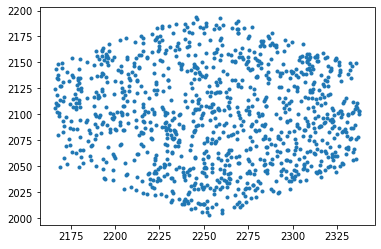

In [47]:
grp_cfg = {
    "columns": ["ss_flat_x", "ss_flat_y"],
    "method": "group_by_grid",
    "args": [100]
}
nrn = conntility.circuit_models.neuron_groups.group_with_config(cmat.vertices, grp_cfg)
display(nrn) # Index determined the groups

plt.plot(nrn.loc[(-8, 34)]["ss_flat_x"], nrn.loc[(-8, 34)]["ss_flat_y"], '.')

An even more complex way of determining subpopulations is by using "filter configurations" instead.
Just as "grouping configurations", they determine subpopulations based on node properties, but in a different way. Instead of using all possible values, or binned values, they specify a list of filters that a node must pass in order to be considered part of the group.

In the example below, we define two groups: One of "L3_TPC:A" and "L2_TPC:B" neurons with depths between 100 and 300; another of the same types with depths between 300 and 500.

In [50]:
lst_decorator = [
    {
        "name": "grouped_population_by_filtering_config",
        "args": [
            [{
                "filtering": [
                    {
                        "column": "depth",
                        "interval": [100, 300]
                    },
                    {
                        "column": "mtype",
                        "values": ["L3_TPC:A", "L2_TPC:B"]
                    }
                ]
            },
            {
                "filtering": [
                    {
                        "column": "depth",
                        "interval": [300, 500]
                    },
                    {
                        "column": "mtype",
                        "values": ["L3_TPC:A", "L2_TPC:B"]
                    }
                ]
            }]
        ]
    }
]

analysis_specs = {
    "analyses":{
        "connection_counts": {
            "source": "simple_analysis_example.py",
            "method": "count_connections",
            "output": "scalar",
            "decorators": lst_decorator
        }
    }
}
cmat.analyze(analysis_specs)

{'connection_counts': depth       mtype                   
 [100, 300]  ['L3_TPC:A', 'L2_TPC:B']    131547
 [300, 500]  ['L3_TPC:A', 'L2_TPC:B']     69007
 dtype: int64}

## Control with random matrices
We might want to compare the results of the analysis to a control. 
To that end, we write a control function that takes a matrix and list of node properties as input and returns a randomized matrix according to some control model. Here we use a very, very primitive model.

Connectome Utilities takes care of running the randomization analzing the results and returning them to the user. This is done by another decorator.

Note that in this case we do not expect significant differences between data and control.

In [7]:
from scipy import sparse

def primitive_er(M, *args):
    return sparse.csc_matrix(numpy.random.rand(*M.shape) < M.mean())

analysis_specs = {
    "analyses":{
        "connection_counts_for_pathways": {
            "source": "simple_analysis_example.py",
            "method": "count_connections",
            "output": "scalar",
            "decorators": [
                {
                    "name": "control_by_randomization",
                    "args": [primitive_er],
                    "kwargs": {"n_randomizations": 5, "only_mean": False}
                }
            ]
        }
    }
}
cmat.analyze(analysis_specs)


{'connection_counts_for_pathways': Control     Instance
 data        0           755427
 randomized  0           754588
             1           756121
             2           754174
             3           756064
             4           755139
 dtype: int64}

Once again, the code for the randomization can be dynamically imported from a python file. This works as follows:

In [10]:
with open("primitive_er.py", "w") as fid:
    fid.write("""
from scipy import sparse
import numpy

def primitive_er(M, *args):
    return sparse.csc_matrix(numpy.random.rand(*M.shape) < M.mean())
""")
    
analysis_specs = {
    "analyses":{
        "connection_counts_for_pathways": {
            "source": "simple_analysis_example.py",
            "method": "count_connections",
            "output": "scalar",
            "decorators": [
                {
                    "name": "control_by_randomization",
                    "analysis_arg":
                    {
                        "random_er":{
                            "source": "primitive_er.py",
                            "method": "primitive_er",
                            "args": [],
                            "kwargs": {},
                            "output": "Matrix"
                        }
                    },
                    "args": [],
                    "kwargs": {"n_randomizations": 5, "only_mean": False}
                }
            ]
        }
    }
}
cmat.analyze(analysis_specs)

{'connection_counts_for_pathways': Control    Instance
 data       0           755427
 random_er  0           755783
            1           754745
            2           755267
            3           755637
            4           755894
 dtype: int64}

## Combining decorators

Note that decorators can be combined and chained.
We can analyze "pathways" separately and also combine results to controls.

In [11]:
analysis_specs = {
    "analyses":{
        "connection_counts_for_pathways": {
            "source": "simple_analysis_example.py",
            "method": "count_connections",
            "output": "scalar",
            "decorators": [
                {
                    "name": "pathways_by_grouping_config",
                    "args": [{"columns": ["mtype"], "method": "group_by_properties"}]
                },
                {
                    "name": "control_by_randomization",
                    "analysis_arg":
                    {
                        "random_er":{
                            "source": "primitive_er.py",
                            "method": "primitive_er",
                            "args": [],
                            "kwargs": {},
                            "output": "Matrix"
                        }
                    },
                    "args": [],
                    "kwargs": {"n_randomizations": 5, "only_mean": False}
                }
            ]
        }
    }
}
cmat.analyze(analysis_specs)

{'connection_counts_for_pathways': Control    Instance  idx-mtype_pre  idx-mtype_post
 data       0         L2_IPC         L2_IPC             1227
                      L2_TPC:A       L2_IPC             1134
                      L2_TPC:B       L2_IPC            10331
                      L3_TPC:A       L2_IPC             8346
                      L3_TPC:C       L2_IPC             2746
                                                       ...  
 random_er  4         L2_IPC         L3_TPC:C           3205
                      L2_TPC:A       L3_TPC:C           5348
                      L2_TPC:B       L3_TPC:C          33017
                      L3_TPC:A       L3_TPC:C          43181
                      L3_TPC:C       L3_TPC:C          12593
 Length: 150, dtype: int64}

When combining decorators, their order matters! In the example above, first the matrix is broken up into submatrices, which are then separately randomized by the control script.

If we swap their order, then first the entire matrix is randomized, and then broken up into "pathways".

In [14]:
analysis_specs = {
    "analyses":{
        "connection_counts_for_pathways": {
            "source": "simple_analysis_example.py",
            "method": "count_connections",
            "output": "scalar",
            "decorators": [
                {
                    "name": "control_by_randomization",
                    "analysis_arg":
                    {
                        "random_er":{
                            "source": "primitive_er.py",
                            "method": "primitive_er",
                            "args": [],
                            "kwargs": {},
                            "output": "Matrix"
                        }
                    },
                    "args": [],
                    "kwargs": {"n_randomizations": 5, "only_mean": True}
                },
                {
                    "name": "pathways_by_grouping_config",
                    "args": [{"columns": ["mtype"], "method": "group_by_properties"}]
                }
            ]
        }
    }
}
cmat.analyze(analysis_specs)